In [1]:
from langchain.chat_models import init_chat_model
from langchain.tools import tool

## Define tools


In [2]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b

## Define model


In [3]:
model = init_chat_model("gpt-4o", temperature=0)

In [4]:
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

model_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x10977b770>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x10a15c2f0>, root_client=<openai.OpenAI object at 0x109778ec0>, root_async_client=<openai.AsyncOpenAI object at 0x10a15c050>, model_name='gpt-4o', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'t

## Define State


In [5]:
import operator

from langchain.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    llm_calls: int

## Define model node


In [6]:
from langchain.messages import HumanMessage, SystemMessage


def llm_call(state: MessagesState) -> MessagesState:
    """LLM decides whether to call a tool or not"""

    return MessagesState(
        messages=[
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        llm_calls=state.get("llm_calls", 0) + 1,
    )

In [7]:
ms = model_with_tools.invoke(
    [HumanMessage(content="Hello! What is 3 multiplied by 4?")]
)
ms.tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 4},
  'id': 'call_OhM5rso2oTbT72V9pFthvRpi',
  'type': 'tool_call'}]

## Define tool node


In [8]:
tool_call = ms.tool_calls[0]
tools_by_name[tool_call["name"]].invoke(tool_call["args"])

12

In [9]:
from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

## Define end logic


In [10]:
from typing import Literal

from langgraph.graph import END, START, StateGraph


def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

## Build and compile the agent


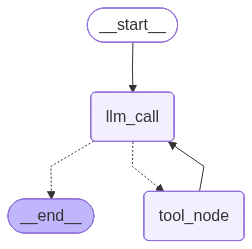

In [11]:
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# nodes
agent_builder.set_entry_point("llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, ["tool_node", END])
agent_builder.add_edge("tool_node", "llm_call")

# Compile agent
agent = agent_builder.compile()

# Show graph
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

## Invoke


In [12]:
from langchain.messages import HumanMessage

messages = [HumanMessage(content="Add 3 and 4. Multiply that by 2")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_kiMAij7tujfXJv6DNZyZxcbZ)
 Call ID: call_kiMAij7tujfXJv6DNZyZxcbZ
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_fLHGN99SkROndptQ2pTOjYV9)
 Call ID: call_fLHGN99SkROndptQ2pTOjYV9
  Args:
    a: 7
    b: 2
================================= Tool Message =================================

14
================================== Ai Message ==================================

The result of adding 3 and 4, and then multiplying by 2 is 14.


In [23]:
from langchain.messages import HumanMessage

messages = [HumanMessage(content="Add 3 and 4. Multiply that by 2. List the tool calls")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply that by 2. List the tool calls
================================== Ai Message ==================================
Tool Calls:
  add (call_RCunPJ6mGO08MK9riUMw79dY)
 Call ID: call_RCunPJ6mGO08MK9riUMw79dY
  Args:
    a: 3
    b: 4
  multiply (call_EjApnkWXKMPyiqo0Mqo5Qnlw)
 Call ID: call_EjApnkWXKMPyiqo0Mqo5Qnlw
  Args:
    a: 7
    b: 2
================================= Tool Message =================================

7
================================= Tool Message =================================

14
================================== Ai Message ==================================

The tool calls made were:

1. `functions.add` with parameters `a: 3` and `b: 4`, which resulted in 7.
2. `functions.multiply` with parameters `a: 7` and `b: 2`, which resulted in 14.


In [13]:
from langchain.messages import HumanMessage

messages_explain = messages["messages"] + [HumanMessage(content="Explain")]
messages_explain = agent.invoke({"messages": messages_explain})
for m in messages_explain["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_kiMAij7tujfXJv6DNZyZxcbZ)
 Call ID: call_kiMAij7tujfXJv6DNZyZxcbZ
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_fLHGN99SkROndptQ2pTOjYV9)
 Call ID: call_fLHGN99SkROndptQ2pTOjYV9
  Args:
    a: 7
    b: 2
================================= Tool Message =================================

14
================================== Ai Message ==================================

The result of adding 3 and 4, and then multiplying by 2 is 14.
================================ Human Message =================================

Explain
================================== Ai Message ==================================

S

### Use middlewares to log state at each step


In [14]:
from langchain.agents import create_agent
from langchain.agents.middleware import after_model


@after_model
def log_state_after_model(state, runtime):
    print()
    print("---------------------------------------")
    print()
    for m in state["messages"]:
        m.pretty_print()


agent_with_logging = create_agent(
    model="gpt-4o", tools=tools, middleware=[log_state_after_model]
)

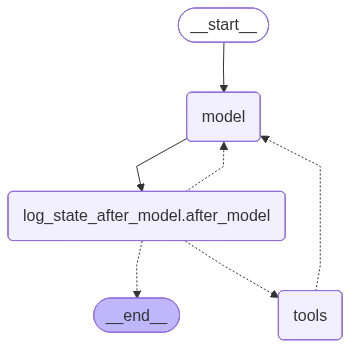

In [15]:
display(Image(agent_with_logging.get_graph(xray=True).draw_mermaid_png()))

In [16]:
messages = [
    HumanMessage(
        content="Add 3 and 4. Also add 2 and 6. Multiply the first result by 2"
    )
]
messages = agent_with_logging.invoke({"messages": messages})


---------------------------------------

================================ Human Message =================================

Add 3 and 4. Also add 2 and 6. Multiply the first result by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_OHrpNsTAReH1T7Uhu1NbZLTf)
 Call ID: call_OHrpNsTAReH1T7Uhu1NbZLTf
  Args:
    a: 3
    b: 4
  add (call_189lpSBUzhqGS3MC1JJRmvHB)
 Call ID: call_189lpSBUzhqGS3MC1JJRmvHB
  Args:
    a: 2
    b: 6

---------------------------------------

================================ Human Message =================================

Add 3 and 4. Also add 2 and 6. Multiply the first result by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_OHrpNsTAReH1T7Uhu1NbZLTf)
 Call ID: call_OHrpNsTAReH1T7Uhu1NbZLTf
  Args:
    a: 3
    b: 4
  add (call_189lpSBUzhqGS3MC1JJRmvHB)
 Call ID: call_189lpSBUzhqGS3MC1JJRmvHB
  Args:
    a: 2
    b: 6
==========================

## Keep short memory between invocations


In [17]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

agent_with_short_memory = create_agent(
    model="gpt-4o",
    tools=tools,
    checkpointer=checkpointer,
)

config = {"configurable": {"thread_id": "1"}}

In [18]:
messages = [
    HumanMessage(
        content="Add 3 and 4. Also add 2 and 6. Multiply the first result by 2"
    )
]
messages = agent_with_short_memory.invoke({"messages": messages}, config=config)

In [19]:
messages = agent_with_short_memory.invoke(
    {"messages": "what did I say earlier?"}, config=config
)

In [20]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Also add 2 and 6. Multiply the first result by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_M9Q3Xs6gelQuQO1Jfr68hmM5)
 Call ID: call_M9Q3Xs6gelQuQO1Jfr68hmM5
  Args:
    a: 3
    b: 4
  add (call_vFisGu9h9BnPdRS3d9q4VSet)
 Call ID: call_vFisGu9h9BnPdRS3d9q4VSet
  Args:
    a: 2
    b: 6
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ZwapmicG768hYePhbMsKIM4p)
 Call ID: call_ZwapmicG768hYePhbMsKIM4p
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ===================

## Use middlewares to trim messages history


In [21]:
from langchain.agents import create_agent
from langchain.agents.middleware import after_model, before_model
from langchain.messages import RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph.message import REMOVE_ALL_MESSAGES


@after_model
def log_state_after_model(state, runtime):
    print()
    print("---------------------------------------")
    print()
    for m in state["messages"]:
        m.pretty_print()


@before_model
def trim_messages(state, runtime):
    print("+++ Trimming messages: keep first and last 2 +++")
    messages = state["messages"]

    if len(messages) <= 3:
        new_messages = messages
    else:
        first_msg = messages[0]
        recent_messages = messages[-2:]
        new_messages = [first_msg] + recent_messages

    return {"messages": [RemoveMessage(id=REMOVE_ALL_MESSAGES), *new_messages]}


agent_with_trimmed_messages = create_agent(
    model="gpt-4o",
    tools=tools,
    middleware=[
        log_state_after_model,
        trim_messages,
    ],
)

config = {"configurable": {"thread_id": "1"}}

In [22]:
messages = [
    HumanMessage(
        content="Add 3 and 4. Also add 2 and 6. Multiply the first result by 2"
    )
]
messages = agent_with_trimmed_messages.invoke({"messages": messages}, config=config)

+++ Trimming messages: keep first and last 2 +++

---------------------------------------

================================ Human Message =================================

Add 3 and 4. Also add 2 and 6. Multiply the first result by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_Tja1hj5dI4Z0RRdTtUZ96VEG)
 Call ID: call_Tja1hj5dI4Z0RRdTtUZ96VEG
  Args:
    a: 3
    b: 4
  add (call_bfrbp3VR4G5O7UROIrrPhJzi)
 Call ID: call_bfrbp3VR4G5O7UROIrrPhJzi
  Args:
    a: 2
    b: 6
+++ Trimming messages: keep first and last 2 +++


BadRequestError: Error code: 400 - {'error': {'message': "Invalid parameter: messages with role 'tool' must be a response to a preceeding message with 'tool_calls'.", 'type': 'invalid_request_error', 'param': 'messages.[1].role', 'code': None}}

## Use TODO middleware


In [ ]:
from langchain.agents import create_agent
from langchain.agents.middleware import TodoListMiddleware, after_model


@after_model
def log_state_after_model(state, runtime):
    print()
    print("---------------------------------------")
    print()
    for m in state["messages"]:
        m.pretty_print()


agent_with_todo = create_agent(
    model="gpt-4o",
    tools=tools,
    middleware=[
        TodoListMiddleware(
            system_prompt="Always create a todo list via write_todos before solving anything"
        ),
        log_state_after_model,
    ],
)

In [ ]:
messages = [
    HumanMessage(
        content="Add 3 and 4. Also add 2 and 6. Multiply the first result by 2. Divide the result by 3. Add first and third operations. Subtract 5 from the final result."
    )
]
result = agent_with_todo.invoke({"messages": messages})

In [ ]:
result["todos"]

In [ ]:
for m in result["messages"]:
    if getattr(m, "tool_calls", None):
        print([tc["name"] for tc in m.tool_calls])

In [ ]:
list(agent_with_short_memory.get_state_history(config))